In [1]:
import sys
sys.path.insert(0, '../tools')

%load_ext prov_magics
import versioned_prov
from qversioned_prov import *

In [2]:
def get_original_reference(ref, result=None):
    D, TX, TX2 = var(3)
    if result is None:
        result = set()
    first = False
    while not first:
        first = True
        query = [(D.bound, TX.bound, TX2.bound) for _ in reference_derived_from(ref, D, text=TX) & entity(D, text=TX2)]
        if query:
            ref, text, text2 = query[0]
            result.add(text)
            result.add(text2)
            first = False
            continue
        query = [(D.bound, TX.bound, TX2.bound) for _ in reference_derived_from_access(ref, D, text=TX) & entity(D, text=TX2)]
        if query:
            ref, text, text2 = query[0]
            result.add(text)
            result.add(text2)
            first = False
            continue
    return ref, result

In [29]:
from collections import namedtuple
from copy import copy
from pprint import pprint

Context = namedtuple("Context", "type to_parts moment")


def neighborhood(context):
    n, move_to_parts, time = context
    
    _ = BLANK
    A, C, D, T, U, W, TX, TX2, TX3 = var("A C D T U W TX TX2 TX3")
    
    # If time is not in the context, get it from the entity
    if not time:
        time = [T.bound for _ in entity(n, T)][0]

    # Follow default derivations
    query = (
        was_derived_from(n, D, _, _, _, TX)
        & entity(D, _, TX2)
    )
    for __ in query:
        yield Context(D.bound, True, None), {TX.bound, TX2.bound}
    
    query = (
        reference_derived_from(n, D, _, _, _, _, TX)
        & entity(D, A, TX2)
    )
    for __ in query:
        yield Context(D.bound, move_to_parts, None), {TX.bound, TX2.bound} 
        

    # Move to whole
    query = (
        reference_derived_from_access(n, D, _, _, _, T, W, _, _, TX)
        & entity(D, _, TX2)
        & entity(W, _, TX3)
        
    )
    for __ in query:
        yield Context(D.bound, move_to_parts, None), {TX.bound, TX2.bound} 
        yield Context(W.bound, False, T.bound), {TX.bound, TX3.bound}
        
    
    if move_to_parts:
        # Get initial reference to value
        original, result = get_original_reference(n)

        # Move to all parts of the structure 
        # Sort derivedByInsertion
        parts = [
            (T.bound, C.bound, TX.bound)
            for __ in derived_by_insertion(n, C, T, TX)
            if T.bound <= time
        ]
        parts.sort()
        # Reconstruct state
        state = {}
        for __, changes, text in parts:
            for key, value in changes:
                for __ in entity(value, _, TX):
                    state[key] = (value,  {text, TX.bound})
        # Move to parts of the state
        for value, text in state.values():
            yield (Context(value, True, time), result | text)
            

def dfs(ent, neigh):
    context = Context(ent, True, None)
    stack = [context]
    visited = set()
    TX = var("text")
    result = {TX.bound for __ in entity(ent, BLANK, TX)} 
    while stack:
        context = stack.pop()
        for other, tresult in neigh(context):
            if other not in visited:
                visited.add(other)
                result |= tresult
                stack.append(other)
    return result

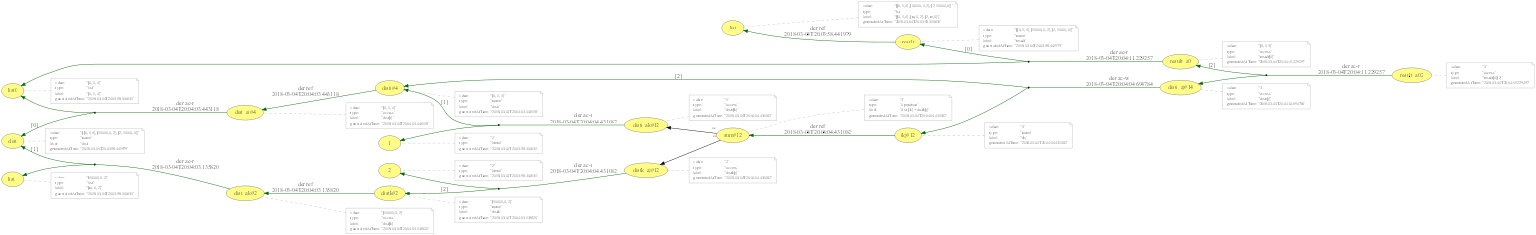

In [30]:
querier.load("../images/versioned_prov/floydwarshall.provn");
view = "provn png svg pdf"
get_ipython().run_cell_magic(
    "provn",
    "-o {} -e {} -r RL".format("../images/versioned_prov/query", view),
    '\n'.join(dfs("result_a02", neighborhood))
)